In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import math


ONEOVERSQRT2PI = 1.0 / math.sqrt(2 * math.pi)


class MDN(nn.Module):
    """A mixture density network layer

    The input maps to the parameters of a MoG probability distribution, where
    each Gaussian has O dimensions and diagonal covariance.

    Arguments:
        in_features (int): the number of dimensions in the input
        out_features (int): the number of dimensions in the output
        num_gaussians (int): the number of Gaussians per output dimensions

    Input:
        minibatch (BxD): B is the batch size and D is the number of input
            dimensions.

    Output:
        (pi, sigma, mu) (BxG, BxGxO, BxGxO): B is the batch size, G is the
            number of Gaussians, and O is the number of dimensions for each
            Gaussian. Pi is a multinomial distribution of the Gaussians. Sigma
            is the standard deviation of each Gaussian. Mu is the mean of each
            Gaussian.
    """

    def __init__(self, in_features, out_features, num_gaussians):
        super(MDN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_gaussians = num_gaussians
        self.pi = nn.Sequential(
            nn.Linear(in_features, num_gaussians),
            nn.Softmax(dim=1)
        )
        self.sigma = nn.Linear(in_features, out_features * num_gaussians)
        self.mu = nn.Linear(in_features, out_features * num_gaussians)

    def forward(self, minibatch):
        pi = self.pi(minibatch)
        sigma = torch.exp(self.sigma(minibatch))
        sigma = sigma.view(-1, self.num_gaussians, self.out_features)
        mu = self.mu(minibatch)
        mu = mu.view(-1, self.num_gaussians, self.out_features)
        return pi, sigma, mu


def gaussian_probability(sigma, mu, target):
    """Returns the probability of `target` given MoG parameters `sigma` and `mu`.

    Arguments:
        sigma (BxGxO): The standard deviation of the Gaussians. B is the batch
            size, G is the number of Gaussians, and O is the number of
            dimensions per Gaussian.
        mu (BxGxO): The means of the Gaussians. B is the batch size, G is the
            number of Gaussians, and O is the number of dimensions per Gaussian.
        target (BxI): A batch of target. B is the batch size and I is the number of
            input dimensions.

    Returns:
        probabilities (BxG): The probability of each point in the probability
            of the distribution in the corresponding sigma/mu index.
    """
    target = target.unsqueeze(1).expand_as(sigma)
    ret = ONEOVERSQRT2PI * torch.exp(-0.5 * ((target - mu) / sigma)**2) / sigma
    return torch.prod(ret, 2)


def mdn_loss(pi, sigma, mu, target):
    """Calculates the error, given the MoG parameters and the target

    The loss is the negative log likelihood of the data given the MoG
    parameters.
    """
    prob = pi * gaussian_probability(sigma, mu, target)
    nll = -torch.log(torch.sum(prob, dim=1))
    return torch.mean(nll)


def sample(pi, sigma, mu):
    """Draw samples from a MoG.
    """
    # Choose which gaussian we'll sample from
    pis = Categorical(pi).sample().view(pi.size(0), 1, 1)
    # Choose a random sample, one randn for batch X output dims
    # Do a (output dims)X(batch size) tensor here, so the broadcast works in
    # the next step, but we have to transpose back.
    gaussian_noise = torch.randn(
        (sigma.size(2), sigma.size(0)), requires_grad=False)
    variance_samples = sigma.gather(1, pis).detach().squeeze()
    mean_samples = mu.detach().gather(1, pis).squeeze()
    return (gaussian_noise * variance_samples + mean_samples).transpose(0, 1)

filtered_data torch.Size([30000, 3])
data torch.Size([40000, 3])


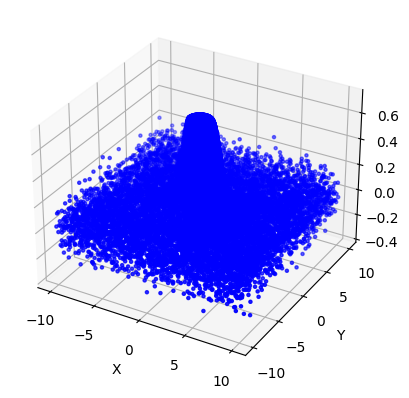

In [5]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate the dataset
x = torch.linspace(-5, 5, 200)
y = torch.linspace(-5, 5, 200)
X, Y = torch.meshgrid(x, y)
R = torch.sqrt(X**2 + Y**2)
Z = torch.exp(-R**2 / 5) * torch.sin(R)
# Convert data to float32
X, Y, Z = X.float(), Y.float(), Z.float()
# Flatten and stack the data
data = torch.stack((X.flatten(), Y.flatten(), Z.flatten()), dim=1)

# Remove data where X < 0 or Y < 0
mask = (data[:, 0] >= 0) | (data[:, 1] >= 0)
filtered_data = data[mask]
print("filtered_data", filtered_data.size())
x = torch.linspace(-10, 10, 100)
y = torch.linspace(-10, 10, 100)
X, Y = torch.meshgrid(x, y)
R = torch.sqrt(X + Y)
noise = torch.randn_like(R)*0.1

X, Y, noise = X.float(), Y.float(), noise.float()
data = torch.stack((X.flatten(), Y.flatten(), noise.flatten()), dim=1)

data = torch.cat((filtered_data, data), 0)
print("data", data.size())

# Split the filtered dataset into features and target
X_data = data[:, :2]
Y_data = data[:, 2:]

# Visualize the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_data[:, 0], X_data[:, 1], Y_data, c='b', marker='o', s=5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()



In [8]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../mdn')

import torch
import torch.nn as nn
import torch.optim as optim

input_dims = 2
output_dims = 1
num_gaussians = 1
print("Initializing model... ", end='')
model = nn.Sequential(
    nn.Linear(input_dims, 100),
    nn.LeakyReLU(0.1),
    nn.Linear(100, 200),
    nn.LeakyReLU(0.1),
    nn.Linear(200, 100),
    nn.LeakyReLU(0.1),
    MDN(100, output_dims, num_gaussians)
)

Initializing model... Done


In [42]:
print('Training model... ', end='')
sys.stdout.flush()
#print(training_set[:, 0:input_dims])
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.05)
for epoch in range(10000):
    model.zero_grad()
    pi, sigma, mu = model(X_data)
    loss = mdn_loss(pi, sigma, mu, Y_data)
    loss.backward()
    optimizer.step()
    print(loss)
    if epoch % 10 == 99:
        print(loss)
        print(f' {round(epoch/50)}%', end='')
        sys.stdout.flush()
print(' Done')


Training model... tensor(-1.6558, grad_fn=<MeanBackward0>)
tensor(-1.6557, grad_fn=<MeanBackward0>)
tensor(-1.6474, grad_fn=<MeanBackward0>)
tensor(-1.6557, grad_fn=<MeanBackward0>)
tensor(-1.6510, grad_fn=<MeanBackward0>)
tensor(-1.6506, grad_fn=<MeanBackward0>)
tensor(-1.6546, grad_fn=<MeanBackward0>)
tensor(-1.6554, grad_fn=<MeanBackward0>)
tensor(-1.6529, grad_fn=<MeanBackward0>)
tensor(-1.6525, grad_fn=<MeanBackward0>)
tensor(-1.6545, grad_fn=<MeanBackward0>)
tensor(-1.6557, grad_fn=<MeanBackward0>)
tensor(-1.6547, grad_fn=<MeanBackward0>)
tensor(-1.6537, grad_fn=<MeanBackward0>)
tensor(-1.6541, grad_fn=<MeanBackward0>)
tensor(-1.6553, grad_fn=<MeanBackward0>)
tensor(-1.6556, grad_fn=<MeanBackward0>)
tensor(-1.6548, grad_fn=<MeanBackward0>)
tensor(-1.6544, grad_fn=<MeanBackward0>)
tensor(-1.6549, grad_fn=<MeanBackward0>)
tensor(-1.6556, grad_fn=<MeanBackward0>)
tensor(-1.6555, grad_fn=<MeanBackward0>)
tensor(-1.6550, grad_fn=<MeanBackward0>)
tensor(-1.6549, grad_fn=<MeanBackward0>

KeyboardInterrupt: ignored

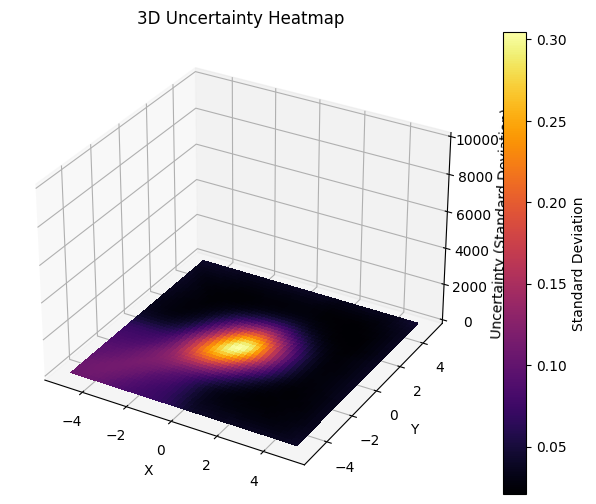

In [43]:
# Predict at new data points
import numpy as np
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X_test = np.array([[xi, yi] for xi in x for yi in y])

# Create 3D heatmap
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
x_grid, y_grid = np.meshgrid(x, y)
X = torch.tensor(x_grid).unsqueeze(-1)
Y = torch.tensor(y_grid).unsqueeze(-1)
xy = torch.cat((X,Y), -1)
xy = xy.reshape(-1,2).type(torch.float32)

pi, sigma, mu = model(xy)
#sigma = torch.sum(torch.squeeze(sigma), -1)
sigma = torch.squeeze(sigma)
sigma = sigma.reshape(100,100).detach().numpy()
surf = ax.plot_surface(x_grid, y_grid, sigma, cmap='inferno', linewidth=0, antialiased=False)
fig.colorbar(surf, ax=ax, label='Standard Deviation')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlim(0, 10000)
ax.set_zlabel('Uncertainty (Standard Deviation)')
plt.title('3D Uncertainty Heatmap')
plt.show()


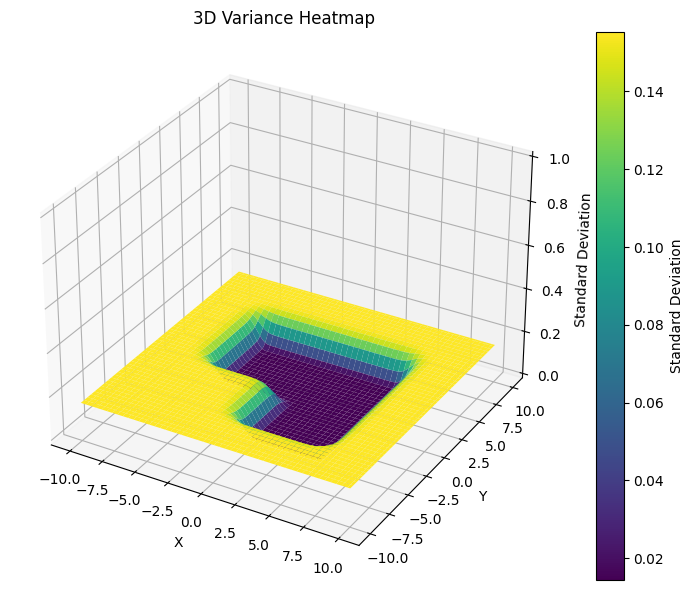